In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df_fp = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk = pd.read_csv("data/gk_data_final.csv", index_col=0)
pd.set_option('display.max_columns', None)

In [22]:
# set random seed for all algos
rseed = 42

In [23]:
# suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [24]:
# suppress future warnings for xgboost in this notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Prepare datasets for prediction | general

In [25]:
# drop irrelevant rows

df_fp = df_fp.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

df_gk = df_gk.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

### Vorgehensweise
1. Für finalen Test --> Test-Set wegpacken
2. Mit train_set train-test-split und predicten
3. Final mit test_set_final predicten

In [26]:
# 1. put final test set aside

# fieldplayers
train_set_fp = df_fp.sample(frac=0.80, random_state=rseed)
y_final_fp = df_fp.drop(train_set_fp.index)
y_final_fp = y_final_fp["market_value_in_euro"]

# goal keepers
train_set_gk = df_gk.sample(frac=0.80, random_state=rseed)
y_final_gk = df_gk.drop(train_set_gk.index)
y_final_gk = y_final_gk["market_value_in_euro"]

print("Fieldplayers: ")
print(train_set_fp.shape)
print(y_final_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)
print(y_final_gk.shape)

Fieldplayers: 
(8598, 54)
(2149,)
-----------------------
Goalkeepers: 
(1110, 37)
(277,)


# Define Pipelines

## Identify best models 

Regressors to be used:
1. Linear Regression
6. Stochastic Gradient Descent
7. Decision Trees
8. Random Forest
9. AdaBoost
10. Gradient Tree Boosting
11. XGBoost


In [27]:
def model_selection (train_set, scaler, encoder):

    ###################################
    # 2.1. train-test-split with remaining 80% of data
    ###################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro"],axis=1)

    y = train_set["market_value_in_euro"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # 2.2. Build preprocessing pipeline with
    # - standard scaler
    # - onehotencoder
    ###################################

    from sklearn.pipeline import Pipeline

    numeric_transformer = Pipeline(steps=[
        ('scaler', scaler)])

    categorical_transformer = Pipeline(steps=[
        ('encoder', encoder)])

    ###################################
    # 2.3. Apply column transformer
    ###################################

    from sklearn.compose import ColumnTransformer

    numeric_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    ###################################
    # 2.4. Fit algorithms
    ###################################

    from sklearn import linear_model
    from sklearn import svm
    from sklearn import tree
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    

    models = []
    models.append(("LR",linear_model.LinearRegression()))
    models.append(("SGD",linear_model.SGDRegressor(random_state=rseed)))
    models.append(("DT",tree.DecisionTreeRegressor(random_state=rseed)))
    models.append(("RF",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("ADA",AdaBoostRegressor(random_state=rseed)))
    models.append(("GDB",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGB",xgb.XGBRegressor(random_state=rseed)))
    

    results = []
    names = []
    scoring = 'neg_root_mean_squared_error'
    
    for name,regressor in models:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
    
        ###################################
        # 2.5. Calculate comparison metric (MRSE) and visualize comparison
        ###################################

        from sklearn.metrics import mean_squared_error
        
        import math
        from math import sqrt
        
        from sklearn import model_selection
        from sklearn.model_selection import cross_val_score

        
        
        kfold = model_selection.KFold(n_splits=5, random_state=rseed, shuffle=True)
        cv_results = abs(model_selection.cross_val_score(pipe, X, y, cv=kfold, scoring=scoring))
        cv_mean = math.ceil(cv_results.mean())
        cv_std = math.ceil(cv_results.std())
        results.append(cv_results)
        names.append(name)
        print(f"{name}: ", f"{cv_mean:0,}", f"({cv_std:0,})")

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR:  2,516,895 (83,029)
SGD:  2,534,518 (84,793)
DT:  2,704,076 (134,011)
RF:  1,933,376 (89,231)
ADA:  4,072,778 (160,561)
GDB:  1,878,289 (121,335)
[10:07:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB:  1,857,981 (120,024)


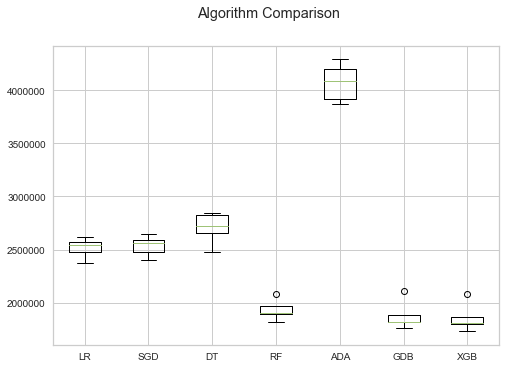

In [28]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

model_selection (train_set_fp, MinMaxScaler(), OneHotEncoder())

###### --> best 3 algorithms (in terms of lowest MRSE) are Random Forests, GDBoost and XGBoost

In [44]:
def best_algos_pipeline (train_set, scaler, encoder):

    ###################################
    # 2.1. train-test-split with remaining 80% of data
    ###################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro"],axis=1)

    y = train_set["market_value_in_euro"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # 2.2. Build preprocessing pipeline with
    # - a scaler for numerical columns
    # - an encoder for categorical columns
    ###################################

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import MinMaxScaler
    

    numeric_transformer = Pipeline(steps=[
        ('scaler', scaler)])

    categorical_transformer = Pipeline(steps=[
        ('encoder', encoder)])

    ###################################
    # 2.3. Apply column transformer
    ###################################

    from sklearn.compose import ColumnTransformer

    numerical_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features)])
    
    X_preprocessed = preprocessor.fit_transform(X)
    
    # get column names for feature importances later
    
    numerical_features_names = list(numerical_features)
    encoded_categorical_features = preprocessor.named_transformers_["cat"]["encoder"]
    encoded_categorical_features_names = list(encoded_categorical_features.get_feature_names(categorical_features))
    column_names = numerical_features_names + encoded_categorical_features_names

    ###################################
    # 2.4. Fit algorithms
    ###################################

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    
    from sklearn.model_selection import RandomizedSearchCV
    

    models = []
    models.append(("Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("Gradient Boost",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGBoost",xgb.XGBRegressor(random_state=rseed)))
    
    fitted_models = []
    
    param_grid = {
        'regressor__n_estimators': [50, 100, 200, 250],
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth' : [3,4,5,12,20,30]
    }

    
    for name,regressor in models:
        model = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        

        grid = RandomizedSearchCV(model, param_grid, cv=5, scoring="r2", random_state=rseed, n_jobs=-1)
        
        grid.fit(X_train, y_train)
        
        y_pred_train = grid.predict(X_train)
        y_pred_test = grid.predict(X_test)
        
        fitted_models.append(grid)
        
        print("----------------------------------------------------------------------------------------------------------")
        print("\033[1m",name,"\033[0m")
        print("----------------------------------------------------------------------------------------------------------")
        print("Best hyperparameters:")
        print(grid.best_params_)
        print("-----------------------")
        print("Best estimator score:")
        print(grid.best_score_)
        print("-----------------------")
        
        # features importances
        
        feature_importances = grid.best_estimator_.named_steps["regressor"].feature_importances_
        feat_imp_df = pd.DataFrame({'feature':column_names,'importance':feature_importances})
        feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
        print("Feature importances:")
        print("------------------------------------------------------------")
        print(feat_imp_df.head(20))
        print("------------------------------------------------------------")
        print("------------------------------------------------------------")
        # Visualization of residuals
        
        from yellowbrick.regressor import residuals_plot
        from yellowbrick.datasets import load_concrete
        
        print(f"Residual plot for {name}")
        viz = residuals_plot(grid, X_train, y_train, X_test, y_test, hist=False)

    return fitted_models, feature_importances

##### Baseline model with all features

----------------------------------------------------------------------------------------------------------
 Random Forest 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'regressor__n_estimators': 200, 'regressor__max_features': 'auto', 'regressor__max_depth': 20}
-----------------------
Best estimator score:
0.7209964740643813
-----------------------
Feature importances:
------------------------------------------------------------
                                feature  importance
3                               overall        0.50
0                            player_age        0.19
85          league_Premier League (ENG)        0.03
21                movement_sprint_speed        0.01
23                   movement_reactions        0.01
19                   skill_ball_control        0.01
28                       power_strength        0.01
41  idfield_defense_positions_avg_score        0.01
18           

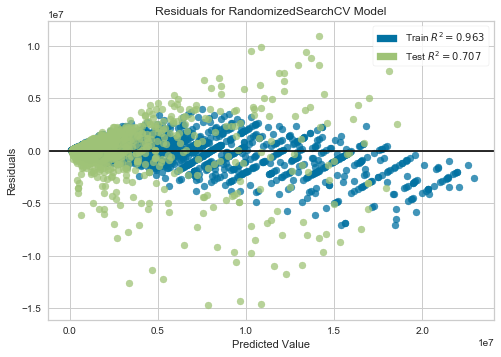

----------------------------------------------------------------------------------------------------------
 Gradient Boost 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'regressor__n_estimators': 50, 'regressor__max_features': 'auto', 'regressor__max_depth': 4}
-----------------------
Best estimator score:
0.7423168005196306
-----------------------
Feature importances:
------------------------------------------------------------
                        feature  importance
3                       overall        0.60
0                    player_age        0.22
85  league_Premier League (ENG)        0.05
21        movement_sprint_speed        0.02
89         league_Serie A (ITA)        0.02
63   league_1. Bundesliga (GER)        0.01
23           movement_reactions        0.01
19           skill_ball_control        0.01
81         league_Ligue 1 (FRA)        0.00
28               power_strength        0.0

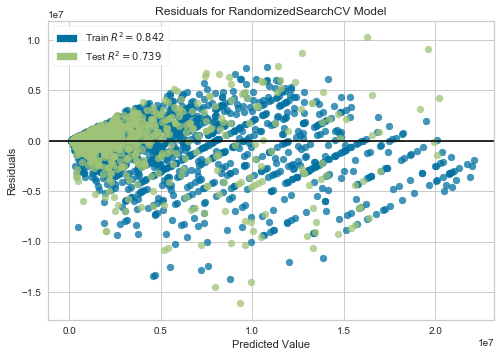

[15:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------------
 XGBoost 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'regressor__n_estimators': 200, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 4}
-----------------------
Best estimator score:
0.7451169689349507
-----------------------
Feature importances:
------------------------------------------------------------
                                 feature  importance
3                                overall        0.27
85           league_Premier League (ENG)        0.09
0                             player_age        0.05
21                 movement_sprint_speed        0.04
89                  league_Serie A (ITA)        0.03
63            league_1. Bundesliga (GER)        0.02
6

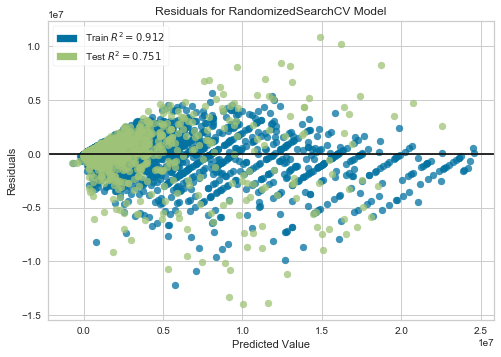

In [45]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

fitted_models, feature_importances = best_algos_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder())

# Residual Analysis

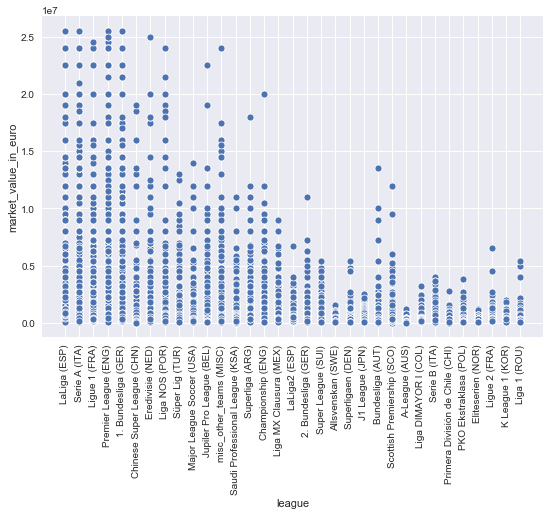

In [104]:
ax = sns.scatterplot(x="league", y="market_value_in_euro", data=df_fp)
plt.xticks(rotation='vertical');

[15:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'regressor__n_estimators': 200, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 4}
-----------------------
Best estimator score:
0.7451169689349507
-----------------------
Feature importances:
------------------------------------------------------------
                                 feature  importance
3                                overall        0.27
85           league_Premier League (ENG)        0.09
0                             player_age        0.05
21                 movement_sprint_speed        0.04
89                  league_Serie A (ITA)        0.03
63            league_1. Bundesliga (GER)        0.02
60         

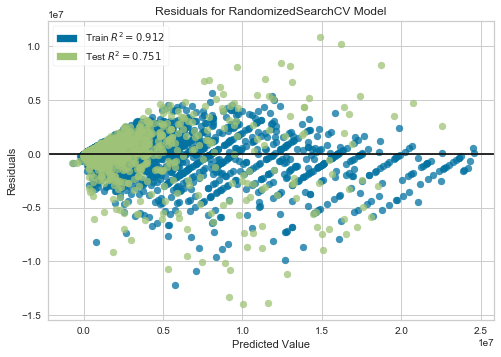

In [49]:
#
###################################
# 2.1. train-test-split with remaining 80% of data
###################################

from sklearn.model_selection import train_test_split

X = train_set_fp.drop(["market_value_in_euro"],axis=1)

y = train_set_fp["market_value_in_euro"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

###################################
# 2.2. Build preprocessing pipeline with
# - a scaler for numerical columns
# - an encoder for categorical columns
###################################

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())])

###################################
# 2.3. Apply column transformer
###################################

from sklearn.compose import ColumnTransformer

numerical_features = train_set_fp.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
categorical_features = train_set_fp.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)])

X_preprocessed = preprocessor.fit_transform(X)

# get column names for feature importances later

numerical_features_names = list(numerical_features)
encoded_categorical_features = preprocessor.named_transformers_["cat"]["encoder"]
encoded_categorical_features_names = list(encoded_categorical_features.get_feature_names(categorical_features))
column_names = numerical_features_names + encoded_categorical_features_names

###################################
# 2.4. Fit algorithm
###################################

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100, 200, 250],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__max_depth' : [3,4,5,12,20,30]
}


model = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor', xgb.XGBRegressor(random_state=rseed))])

grid = RandomizedSearchCV(model, param_grid, cv=5, scoring="r2", random_state=rseed, n_jobs=-1)

grid.fit(X_train, y_train)

y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)


print("----------------------------------------------------------------------------------------------------------")
print("----------------------------------------------------------------------------------------------------------")
print("Best hyperparameters:")
print(grid.best_params_)
print("-----------------------")
print("Best estimator score:")
print(grid.best_score_)
print("-----------------------")

# features importances

feature_importances = grid.best_estimator_.named_steps["regressor"].feature_importances_
feat_imp_df = pd.DataFrame({'feature':column_names,'importance':feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print("Feature importances:")
print("------------------------------------------------------------")
print(feat_imp_df.head(20))
print("------------------------------------------------------------")
print("------------------------------------------------------------")
# Visualization of residuals

from yellowbrick.regressor import residuals_plot
from yellowbrick.datasets import load_concrete

viz = residuals_plot(grid, X_train, y_train, X_test, y_test, hist=False)

In [50]:
X_train.head()

,player_age,geographical_continent,main_position,positional_flexibility,league,division,current_national_player,national_team_appearances,overall,preferred_foot,weak_foot,attacking_work_rate,defensive_work_rate,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,attack_positions_avg_score,midfield_attack_positions_avg_score,idfield_defense_positions_avg_score,defense_positions_avg_score
9700,20,Europe,Centre Midfield,Medium,PKO Ekstraklasa (POL),1,False,0,59,Right,3 Stars,Medium,Medium,2 Star Moves,64,40,52,58,56,66,44,35,49,55,35,55,43,41,61,58,66,63,68,54,66,57,62,77,64,31,56,59,52,53,52,48,56,56,57,51,53,56,56
5615,31,Oceania/Australia,Left Wingback,Low,A-League (AUS),1,False,10,68,Left,3 Stars,Medium,Medium,3 Star Moves,77,51,63,69,63,68,66,53,46,68,58,65,62,46,56,67,76,77,85,66,90,41,91,75,62,49,67,63,63,60,59,65,65,65,65,61,64,63,65
999,29,Europe,Left Wingback,Low,Premier League (ENG),1,True,9,76,Left,4 Stars,High,Low,3 Star Moves,87,68,70,76,72,71,68,66,61,73,60,76,64,68,74,77,86,87,78,72,76,75,91,80,63,69,75,69,74,68,46,67,72,75,76,72,73,73,72
9360,27,Asia,Left Wingback,Low,K League 1 (KOR),1,False,0,61,Left,3 Stars,Medium,High,2 Star Moves,66,24,33,47,60,68,32,21,55,36,25,34,26,34,35,59,63,68,59,57,69,21,75,69,74,25,52,64,47,31,26,69,51,67,64,42,42,48,57
8303,21,Europe,Centre Back,Medium,Eredivisie (NED),1,False,0,63,Left,2 Stars,Medium,Medium,2 Star Moves,63,28,43,49,62,69,32,19,61,56,27,41,29,24,58,61,62,63,48,52,56,48,68,63,75,25,60,57,30,27,40,55,63,66,59,43,44,52,58


In [57]:
# put together datasets again
df_fp_train = X_train.copy()
df_fp_train["y_actual"] = y_train
df_fp_train["y_predicted"] = y_pred_train

df_fp_test = X_test.copy()
df_fp_test["y_actual"] = y_test
df_fp_test["y_predicted"] = y_pred_test

# calculate residuals
df_fp_train["residuals"] = df_fp_train["y_actual"] - df_fp_train["y_predicted"]
df_fp_test["residuals"] = df_fp_test["y_actual"] - df_fp_test["y_predicted"]


# calculate R2 score
ssr_train = np.sum((df_fp_train["y_predicted"] - df_fp_train["y_actual"])**2)
ssr_test = np.sum((df_fp_test["y_predicted"] - df_fp_test["y_actual"])**2)

sst_train = np.sum((df_fp_train["y_actual"] - np.mean(df_fp_train["y_actual"]))**2)
sst_test = np.sum((df_fp_test["y_actual"] - np.mean(df_fp_test["y_actual"]))**2)

r2_score_train = 1 - (ssr_train/sst_train)
r2_score_test = 1 - (ssr_test/sst_test)

print(round(r2_score_train,3))
print(round(r2_score_test,3))

0.912
0.751


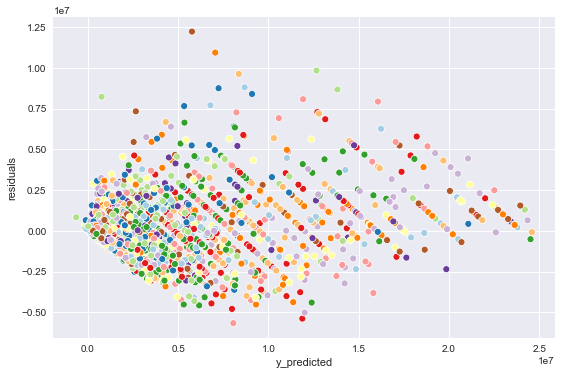

In [106]:
plt.style.use("seaborn")
ax = sns.scatterplot(x="y_predicted", y="residuals", hue="overall",data=df_fp_train, 
                     legend=False, palette="Paired")

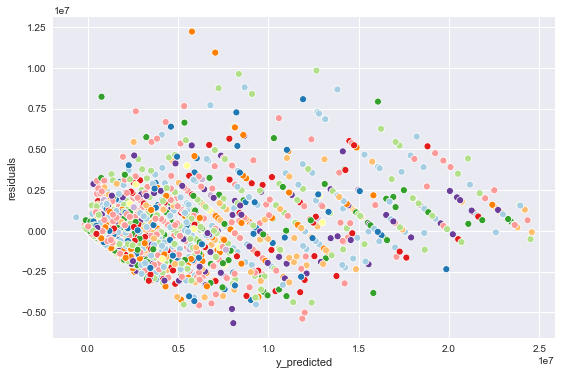

In [100]:
plt.style.use("seaborn")
ax = sns.scatterplot(x="y_predicted", y="residuals", hue="main_position",data=df_fp_train, 
                     legend=False, palette="Paired")

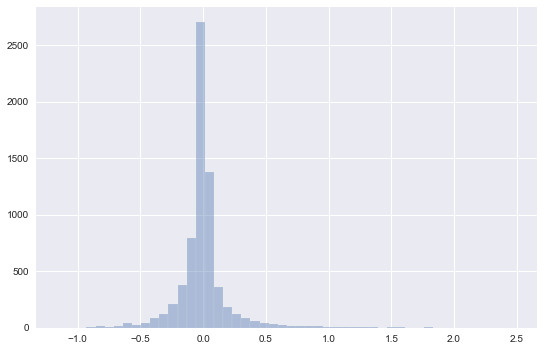

In [83]:
# normalize residuals
plt.style.use("seaborn")
norm_resids = [float(i)/sum(df_fp_train["residuals"]) for i in df_fp_train["residuals"]]
sns.distplot(norm_resids, kde=False)

# ToDos
- diagonal structure in residuals?
- alle regressionsmodelle checken
- alle categoricals checken
- prozentualer fehler als distplot

# todos after 2'

- feature selection
- features importances --> feature engineering and adjustments to dataset --> recursive feature elimination
- model selection(k-best)
- stacking
